In [1]:
!pip install -U segmentation-models-pytorch albumentations --user
import torch
import numpy
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from torchvision.transforms import ToTensor, ToPILImage
from torch.utils.data import Dataset, DataLoader
import cv2

import matplotlib.pyplot as plt
%matplotlib inline

Requirement already up-to-date: segmentation-models-pytorch in /home/kikos/.local/lib/python3.8/site-packages (0.2.0)
Requirement already up-to-date: albumentations in /home/kikos/.local/lib/python3.8/site-packages (1.0.3)


In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [3]:
import os
import pandas as pd
import random
import json
import math
from tqdm import tqdm
from torchvision.io import read_image
from sklearn.cluster import DBSCAN, KMeans
import numpy as np
import torch.optim as optim
import pickle
from IPython.display import clear_output

In [4]:
def classnum(shape):
    return 1
    if shape['label'] == 'fence':
        return 1
    if shape['label'] == 'forbidden':
        return 1
    if shape['label'] == 'building':
        return 1
    return shape['label']

def vec(x0, y0, x1, y1):
    return x0 * y1 - x1 * y0

def calc_vec(a, b, c):
    return vec(b[0] - a[0], b[1] - a[1], c[0] - a[0], c[1] - a[1])

def intersec(a, b, c, d):
    return calc_vec(a, b, c) * calc_vec(a, b, d) < 0 and calc_vec(c, d, b) * calc_vec(c, d, a) < 0

def prepare(pic):
    res = pic / 255
    return res

def detect(x, y, shape):
    if shape['shape_type'] == 'Line':
        v0, v1 = shape['points']
        a = v1[1] - v0[1]
        b = v0[0] - v1[0]
        c = -(v1[0] * a + v1[1] * b)
        if a ** 2 + b ** 2 == 0:
            return False
        d = (a * x + b * y + c) / math.sqrt(a ** 2 + b ** 2)
        between = ((x - v0[0]) * (v1[0] - v0[0]) + (y - v0[1]) * (v1[1] - v0[1]) ) >= 0 and ((x - v1[0]) * (v0[0] - v1[0]) + (y - v1[1]) * (v0[1] - v1[1]) ) >= 0
        return abs(d) < 3 and between
    if shape['shape_type'].startswith('line'):
        for i in range(len(shape['points']) - 1):
            line = {'points': [shape['points'][i], shape['points'][i + 1]],
                    'shape_type': 'Line'}
            if detect(x, y, line):
                return True
        return False
    if shape['shape_type'] == 'polygon':
        s = 0
        other = [10002.7, 10000.5] 
        for i in range(len(shape['points'])):
            point = shape['points'][i]
            next_point = shape['points'][(i + 1) % len(shape['points'])]
            if intersec([x, y], other, point, next_point):
                s += 1
        if s % 2 != 0:
#             print(x, y, s, shape)
            return True
        return False
    return False
            

def create_Xy(sz=20):
    labels = []
    data = []
    for label_id in tqdm(range(sz)):
        labels.append([])
        labels[-1].append([])
        pic, annotation, l, t = dataset[label_id]
        data.append(prepare(pic))
        for i in range(dataset.size):
            labels[-1][-1].append([])
            for j in range(dataset.size):
                labels[-1][-1][-1].append(0)
                for shape in annotation['shapes']:
                    if detect(j + t, i + l, shape):
                        labels[-1][-1][-1][-1] = float(classnum(shape))
                        break
    data_tensor = torch.tensor(np.array(data, dtype=float)).permute(0, 3, 1, 2).float()
    labels_tensor = torch.tensor(labels)
    return data_tensor, labels_tensor

class DraftDataset(Dataset):
    def __init__(self, annotations_file, data_dir, transform=None, target_transform=None):
        self.labels = pd.read_csv(annotations_file)
        self.img_dir = data_dir
        self.transform = transform
        self.target_transform = target_transform
        self.length = self.labels.shape[0]
        self.size = 100
        self.images = []
        self.annotations = []
        self.X = pickle.load(open('data/X.data', 'rb'))
        self.y = pickle.load(open('data/y.data', 'rb'))
#         self.masks = pickle.load(open('data/y.data', 'rb'))
#         self.masks_processed = []
#         for idx in range(0, self.length):
#             assert idx < len(self.labels)
#             img_path = os.path.join(self.img_dir, self.labels.iloc[idx, 0] + '.jpg')
#             print('Processing {0}'.format(img_path))
#             pic = cv2.imread(img_path)
#             b, g, r = cv2.split(pic)
#             self.images.append(cv2.merge([r, g, b]))
#         for idx in range(len(self.masks), self.length):
#             assert idx < len(self.labels)
#             img_path = os.path.join(self.img_dir, self.labels.iloc[idx, 0] + '.jpg')
#             print('Processing {0}'.format(img_path))
#             pic = cv2.imread(img_path)
#             b, g, r = cv2.split(pic) # по умолчанию cv2 почему-то отдает цвета в порядке BGR вместо RGB
#             self.images.append(cv2.merge([r, g, b]))
#             self.annotations.append(json.load(open(data_dir + self.labels.iloc[idx, 0] + '.json', 'r')))
#             img = self.images[-1]
#             annotation = self.annotations[-1]
#             img_shape = img.shape
#             mask = np.zeros(shape=(img_shape[0], img_shape[1]))
#             for i in tqdm(range(img_shape[0]), desc='X loop', position=0, leave=True):
#                 for j in range(img_shape[1]):
#                     for shape in annotation['shapes']:
#                         if detect(j, i, shape): # проблема с индексацией labelme
#                             mask[i][j] = float(classnum(shape))
#                             break
#             self.masks.append(mask)
#             print('Saving')
#             pickle.dump(self.masks, open('data/y.data', 'wb'))
#             clear_output(wait=True)
#         self.X = self.images
#         self.y = self.masks
    
    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        idx = idx % self.length
        img = self.X[idx]
        mask = self.y[idx]
        return img, mask

In [5]:
dataset = DraftDataset('data/annotations.csv', 'data/')

In [6]:
# pickle.dump(dataset.y, open('data/Y.data', 'wb'))
# pickle.dump(dataset.X, open('data/X.data', 'wb'))

In [7]:
from datetime import datetime
data_size = 250
class AugmentedDataset(Dataset):
    def __init__(self, draft, augmentor):
        self.draft = draft
        self.augmentor = augmentor
    
    def __len__(self):
        return data_size

    def __getitem__(self, idx):
        X, y = dataset[idx]
        augmented = aug(image=X, mask=y)
        X = (torch.tensor(augmented['image']).permute(2, 0, 1) / 256).float()
        y = torch.tensor(augmented['mask']).float().view(1, 256, 256)
#         y_res = torch.zeros(size=(2, y.shape[0], y.shape[1]))
#         for i, row in enumerate(y):
#             for j, item in enumerate(row):
#                 y_res[int(item)][i][j] = 1
        return X, y

In [8]:
import albumentations as A
import segmentation_models_pytorch as smp

aug = A.Compose([
        A.RandomCrop(width=256, height=256, p=1),
        A.RandomRotate90(),
        A.Flip(),
        A.Transpose(),
        A.GaussNoise(p=.2),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
        A.OneOf([
            A.OpticalDistortion(p=0.3),
            A.GridDistortion(p=.1),
        ], p=0.2),
        A.OneOf([
            A.CLAHE(clip_limit=2),
            A.RandomBrightnessContrast(),            
        ], p=0.3),
])   

batch_size = 32
data = AugmentedDataset(dataset, aug)
dataloader = DataLoader(data, batch_size=batch_size, shuffle=True)

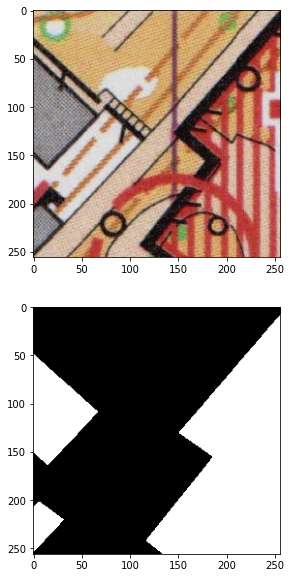

In [9]:
# def view_mask(y):
#     y_res = np.zeros(shape=(y.shape[0], y.shape[1]))
#     for i, row in enumerate(y):
#         for j, item in enumerate(row):
#             y_res[i][j] = item[1]
#     return y_res
X, y = data[15]
X = X.permute(1, 2, 0)
y = y[0]
fig = plt.figure(figsize=(10, 10))
fig.add_subplot(2, 1, 1)
plt.imshow(X)
fig.add_subplot(2, 1, 2)
plt.imshow(y, cmap='gray')

In [10]:
model = smp.Unet(
    encoder_name="resnet18",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,                      # model output channels (number of classes in your dataset)
    activation='sigmoid'
)
model = torch.load('data/09-08-16-50.pt')
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])  
loss = smp.utils.losses.BCELoss()
metrics = [
    smp.utils.metrics.Precision(),
    smp.utils.metrics.Recall(),
    smp.utils.metrics.Accuracy(),
]


train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    optimizer=optimizer,
    metrics=metrics,
    verbose=True,
)


In [11]:
from datetime import datetime

for epoch in range(500):
    print('\nEpoch: {}'.format(epoch))
    train_epoch.run(dataloader)
    
    torch.save(model, 'data/' + datetime.now().strftime('%m.%d-%H:%M:%S') + '.pt')


Epoch: 0
train:   0%|          | 0/8 [00:00<?, ?it/s]

/home/kikos/.local/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


train: 100%|██████████| 8/8 [01:55<00:00, 14.41s/it, bce_loss - 0.1009, precision - 0.9446, recall - 0.9468, accuracy - 0.9606]

Epoch: 1
train: 100%|██████████| 8/8 [01:55<00:00, 14.43s/it, bce_loss - 0.09468, precision - 0.9484, recall - 0.9437, accuracy - 0.9628]

Epoch: 2
train: 100%|██████████| 8/8 [01:53<00:00, 14.24s/it, bce_loss - 0.101, precision - 0.9415, recall - 0.9487, accuracy - 0.9603]  

Epoch: 3
train: 100%|██████████| 8/8 [01:53<00:00, 14.16s/it, bce_loss - 0.09472, precision - 0.9472, recall - 0.9459, accuracy - 0.9627]

Epoch: 4
train: 100%|██████████| 8/8 [01:53<00:00, 14.17s/it, bce_loss - 0.09774, precision - 0.9447, recall - 0.9502, accuracy - 0.9617]

Epoch: 5
train: 100%|██████████| 8/8 [01:52<00:00, 14.11s/it, bce_loss - 0.1051, precision - 0.9337, recall - 0.9408, accuracy - 0.9574]

Epoch: 6
train: 100%|██████████| 8/8 [01:53<00:00, 14.17s/it, bce_loss - 0.1031, precision - 0.9432, recall - 0.942, accuracy - 0.9596]  

Epoch: 7
train: 100%|██████████| 8/8 [

train: 100%|██████████| 8/8 [01:53<00:00, 14.21s/it, bce_loss - 0.0937, precision - 0.9385, recall - 0.9536, accuracy - 0.9628] 

Epoch: 59
train: 100%|██████████| 8/8 [01:55<00:00, 14.38s/it, bce_loss - 0.0927, precision - 0.9486, recall - 0.9434, accuracy - 0.9631] 

Epoch: 60
train: 100%|██████████| 8/8 [01:53<00:00, 14.21s/it, bce_loss - 0.09131, precision - 0.9448, recall - 0.9556, accuracy - 0.9626]

Epoch: 61
train: 100%|██████████| 8/8 [01:53<00:00, 14.23s/it, bce_loss - 0.08492, precision - 0.9523, recall - 0.9522, accuracy - 0.9669]

Epoch: 62
train: 100%|██████████| 8/8 [01:54<00:00, 14.27s/it, bce_loss - 0.08872, precision - 0.9474, recall - 0.9509, accuracy - 0.964] 

Epoch: 63
train: 100%|██████████| 8/8 [01:54<00:00, 14.28s/it, bce_loss - 0.08225, precision - 0.9516, recall - 0.9537, accuracy - 0.9667]

Epoch: 64
train: 100%|██████████| 8/8 [01:53<00:00, 14.20s/it, bce_loss - 0.0855, precision - 0.9487, recall - 0.9467, accuracy - 0.9651] 

Epoch: 65
train: 100%|████████

train: 100%|██████████| 8/8 [01:53<00:00, 14.18s/it, bce_loss - 0.08213, precision - 0.9506, recall - 0.9512, accuracy - 0.9658]

Epoch: 117
train: 100%|██████████| 8/8 [01:53<00:00, 14.20s/it, bce_loss - 0.08101, precision - 0.9457, recall - 0.9543, accuracy - 0.9666]

Epoch: 118
train: 100%|██████████| 8/8 [01:53<00:00, 14.19s/it, bce_loss - 0.0791, precision - 0.9558, recall - 0.9485, accuracy - 0.968]  

Epoch: 119
train: 100%|██████████| 8/8 [01:53<00:00, 14.19s/it, bce_loss - 0.08622, precision - 0.9466, recall - 0.9535, accuracy - 0.9645]

Epoch: 120
train: 100%|██████████| 8/8 [01:53<00:00, 14.19s/it, bce_loss - 0.07855, precision - 0.9549, recall - 0.9586, accuracy - 0.9684]

Epoch: 121
train: 100%|██████████| 8/8 [01:53<00:00, 14.17s/it, bce_loss - 0.07734, precision - 0.9594, recall - 0.9531, accuracy - 0.9683]

Epoch: 122
train: 100%|██████████| 8/8 [01:53<00:00, 14.23s/it, bce_loss - 0.07621, precision - 0.9487, recall - 0.9634, accuracy - 0.9685]

Epoch: 123
train: 100%|█

train: 100%|██████████| 8/8 [01:53<00:00, 14.22s/it, bce_loss - 0.0738, precision - 0.9597, recall - 0.954, accuracy - 0.9696]  

Epoch: 175
train: 100%|██████████| 8/8 [01:59<00:00, 14.89s/it, bce_loss - 0.07482, precision - 0.9548, recall - 0.9584, accuracy - 0.9688]

Epoch: 176
train: 100%|██████████| 8/8 [02:22<00:00, 17.86s/it, bce_loss - 0.07499, precision - 0.9546, recall - 0.9577, accuracy - 0.9691]

Epoch: 177
train: 100%|██████████| 8/8 [02:19<00:00, 17.40s/it, bce_loss - 0.07193, precision - 0.9572, recall - 0.9549, accuracy - 0.9701]

Epoch: 178
train: 100%|██████████| 8/8 [02:00<00:00, 15.11s/it, bce_loss - 0.07819, precision - 0.9506, recall - 0.9554, accuracy - 0.9681]

Epoch: 179
train: 100%|██████████| 8/8 [02:00<00:00, 15.06s/it, bce_loss - 0.07512, precision - 0.9524, recall - 0.964, accuracy - 0.9692] 

Epoch: 180
train: 100%|██████████| 8/8 [02:11<00:00, 16.48s/it, bce_loss - 0.07446, precision - 0.9644, recall - 0.9448, accuracy - 0.9691]

Epoch: 181
train: 100%|█

train: 100%|██████████| 8/8 [01:53<00:00, 14.18s/it, bce_loss - 0.07271, precision - 0.9521, recall - 0.963, accuracy - 0.9696] 

Epoch: 233
train: 100%|██████████| 8/8 [01:53<00:00, 14.14s/it, bce_loss - 0.07875, precision - 0.9532, recall - 0.9556, accuracy - 0.9675]

Epoch: 234
train: 100%|██████████| 8/8 [01:53<00:00, 14.15s/it, bce_loss - 0.07555, precision - 0.9576, recall - 0.9569, accuracy - 0.9684]

Epoch: 235
train: 100%|██████████| 8/8 [01:55<00:00, 14.40s/it, bce_loss - 0.06774, precision - 0.9562, recall - 0.9622, accuracy - 0.9718]

Epoch: 236
train: 100%|██████████| 8/8 [01:53<00:00, 14.25s/it, bce_loss - 0.06931, precision - 0.9608, recall - 0.9603, accuracy - 0.9705]

Epoch: 237
train: 100%|██████████| 8/8 [01:53<00:00, 14.22s/it, bce_loss - 0.07157, precision - 0.9607, recall - 0.9594, accuracy - 0.9704]

Epoch: 238
train: 100%|██████████| 8/8 [01:53<00:00, 14.17s/it, bce_loss - 0.0756, precision - 0.9523, recall - 0.958, accuracy - 0.9684]  

Epoch: 239
train: 100%|█

train: 100%|██████████| 8/8 [01:54<00:00, 14.28s/it, bce_loss - 0.08893, precision - 0.9429, recall - 0.9573, accuracy - 0.9641]

Epoch: 291
train: 100%|██████████| 8/8 [01:53<00:00, 14.17s/it, bce_loss - 0.07412, precision - 0.96, recall - 0.9558, accuracy - 0.969]   

Epoch: 292
train: 100%|██████████| 8/8 [01:53<00:00, 14.16s/it, bce_loss - 0.07183, precision - 0.9525, recall - 0.9567, accuracy - 0.9702]

Epoch: 293
train: 100%|██████████| 8/8 [01:53<00:00, 14.23s/it, bce_loss - 0.08386, precision - 0.9515, recall - 0.9571, accuracy - 0.966] 

Epoch: 294
train: 100%|██████████| 8/8 [01:53<00:00, 14.22s/it, bce_loss - 0.08862, precision - 0.9546, recall - 0.9429, accuracy - 0.965] 

Epoch: 295
train: 100%|██████████| 8/8 [01:53<00:00, 14.15s/it, bce_loss - 0.08393, precision - 0.9447, recall - 0.9512, accuracy - 0.9647]

Epoch: 296
train: 100%|██████████| 8/8 [01:54<00:00, 14.29s/it, bce_loss - 0.08281, precision - 0.9496, recall - 0.9503, accuracy - 0.9655]

Epoch: 297
train: 100%|█

train: 100%|██████████| 8/8 [01:54<00:00, 14.32s/it, bce_loss - 0.07552, precision - 0.9534, recall - 0.9518, accuracy - 0.9689]

Epoch: 349
train: 100%|██████████| 8/8 [01:53<00:00, 14.20s/it, bce_loss - 0.0691, precision - 0.9613, recall - 0.961, accuracy - 0.9717]  

Epoch: 350
train: 100%|██████████| 8/8 [01:53<00:00, 14.22s/it, bce_loss - 0.06612, precision - 0.9592, recall - 0.9589, accuracy - 0.9719]

Epoch: 351
train: 100%|██████████| 8/8 [01:53<00:00, 14.20s/it, bce_loss - 0.06526, precision - 0.9596, recall - 0.9586, accuracy - 0.9722]

Epoch: 352
train: 100%|██████████| 8/8 [01:53<00:00, 14.14s/it, bce_loss - 0.07075, precision - 0.9574, recall - 0.9584, accuracy - 0.9703]

Epoch: 353
train: 100%|██████████| 8/8 [01:53<00:00, 14.16s/it, bce_loss - 0.06573, precision - 0.9614, recall - 0.9583, accuracy - 0.9727]

Epoch: 354
train: 100%|██████████| 8/8 [01:53<00:00, 14.13s/it, bce_loss - 0.06844, precision - 0.9568, recall - 0.9603, accuracy - 0.9708]

Epoch: 355
train: 100%|█

train: 100%|██████████| 8/8 [01:54<00:00, 14.27s/it, bce_loss - 0.06459, precision - 0.9668, recall - 0.9606, accuracy - 0.973] 

Epoch: 407
train: 100%|██████████| 8/8 [01:53<00:00, 14.17s/it, bce_loss - 0.06546, precision - 0.9599, recall - 0.9569, accuracy - 0.9728]

Epoch: 408
train: 100%|██████████| 8/8 [01:54<00:00, 14.32s/it, bce_loss - 0.0577, precision - 0.964, recall - 0.968, accuracy - 0.9758]   

Epoch: 409
train: 100%|██████████| 8/8 [01:54<00:00, 14.25s/it, bce_loss - 0.06611, precision - 0.9589, recall - 0.9541, accuracy - 0.9719]

Epoch: 410
train: 100%|██████████| 8/8 [01:53<00:00, 14.16s/it, bce_loss - 0.07313, precision - 0.9569, recall - 0.9607, accuracy - 0.9696]

Epoch: 411
train: 100%|██████████| 8/8 [01:53<00:00, 14.17s/it, bce_loss - 0.06881, precision - 0.9559, recall - 0.9584, accuracy - 0.9715]

Epoch: 412
train: 100%|██████████| 8/8 [01:53<00:00, 14.20s/it, bce_loss - 0.06832, precision - 0.9639, recall - 0.9563, accuracy - 0.9715]

Epoch: 413
train: 100%|█

train: 100%|██████████| 8/8 [01:55<00:00, 14.45s/it, bce_loss - 0.06337, precision - 0.9563, recall - 0.9599, accuracy - 0.9733]

Epoch: 465
train: 100%|██████████| 8/8 [01:56<00:00, 14.51s/it, bce_loss - 0.06282, precision - 0.9648, recall - 0.9625, accuracy - 0.9737]

Epoch: 466
train: 100%|██████████| 8/8 [01:56<00:00, 14.56s/it, bce_loss - 0.06139, precision - 0.96, recall - 0.9629, accuracy - 0.9738]  

Epoch: 467
train: 100%|██████████| 8/8 [01:55<00:00, 14.45s/it, bce_loss - 0.06109, precision - 0.9642, recall - 0.9589, accuracy - 0.9743]

Epoch: 468
train: 100%|██████████| 8/8 [01:55<00:00, 14.48s/it, bce_loss - 0.06992, precision - 0.9626, recall - 0.96, accuracy - 0.9725]  

Epoch: 469
train: 100%|██████████| 8/8 [01:56<00:00, 14.53s/it, bce_loss - 0.06721, precision - 0.9577, recall - 0.9631, accuracy - 0.9722]

Epoch: 470
train: 100%|██████████| 8/8 [01:56<00:00, 14.52s/it, bce_loss - 0.06442, precision - 0.9631, recall - 0.9567, accuracy - 0.9729]

Epoch: 471
train: 100%|█

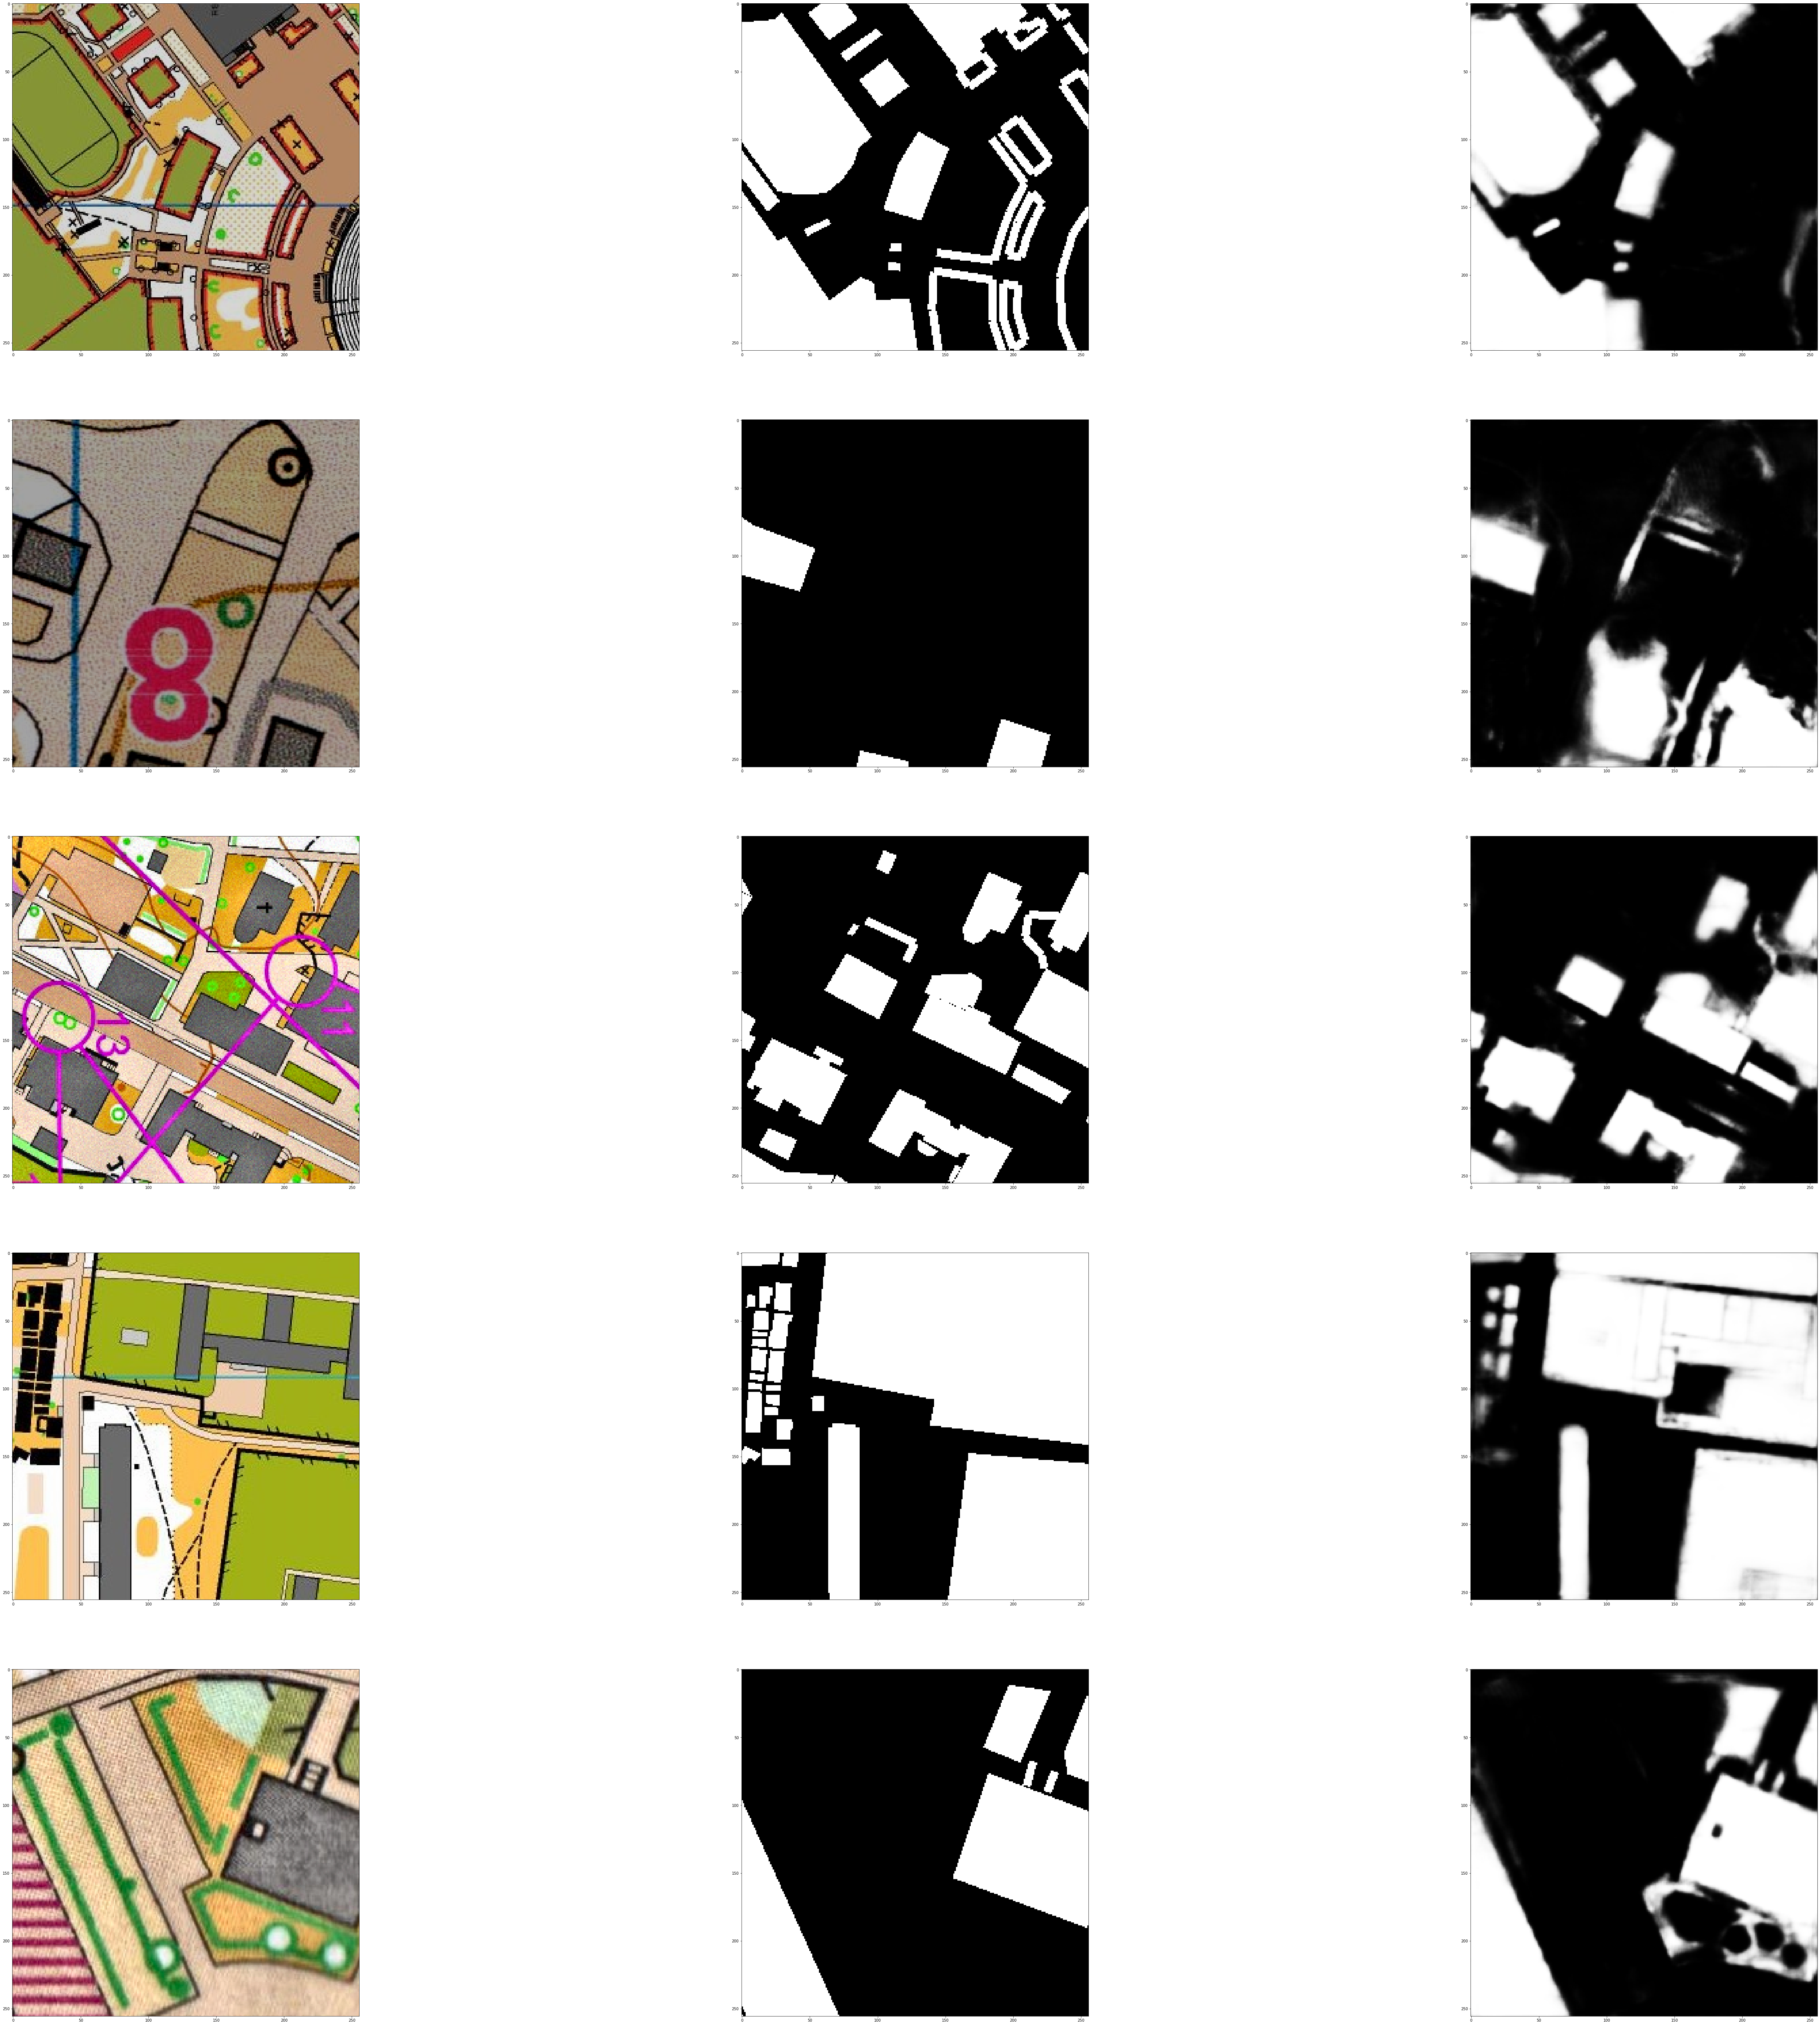

In [12]:
fig = plt.figure(figsize=(100, 100))
for i in range(5):
    X, y = data[random.randint(12345, 23456)]
    X = X.view(1, 3, 256, 256)
    pred = model(X)
    fig.add_subplot(5, 3, 3 * i + 1)
    plt.imshow(X[0].permute(1, 2, 0).detach().numpy())
    fig.add_subplot(5, 3, 3 * i + 2)
    plt.imshow(y[0], cmap='gray')
    fig.add_subplot(5, 3, 3 * i + 3)
    plt.imshow(pred[0][0].detach().numpy(), cmap='gray')
plt.show()

In [14]:
torch.save(model, 'data/09-08-16-50.pt')